# Packages Importing

In [1]:
import pandas as pd
import urllib.request, json
import zipfile
from datetime import date, timedelta
import xlrd
from geopy import Nominatim
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import folium
import requests
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Extracting, transforming and Loading our data.


### Extracting Bases from the New York city site for all the prices of property sales in Manhattan

In [2]:
url = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/neighborhood_sales/2019/2019_manhattan_sales_prices.xlsx'
urllib.request.urlretrieve(url, '2019_manhattan_sales_prices.xlsx')


('2019_manhattan_sales_prices.xlsx',
 <http.client.HTTPMessage at 0x1a6dfcf1e48>)


### Appending all the xlsx sheets from the last 6 years from the NYC site, in order to form one major base.

In [3]:
sheets = pd.read_excel('2019_manhattan_sales_prices.xlsx', 
                       sheet_name = ['2014 Sales','2015 Sales','2016 Sales', '2017 Sales', '2018 Sales','2019 Sales' ])

In [4]:
df = pd.concat(sheets[frame] for frame in sheets.keys())
df2 = df.rename(columns=df.iloc[2])
df3 = df2.drop(df2.index[:3])

### As there is no pattern in the column "Type of Home', we will use only the two numbers from the beginning that indicates the type. This will also help when we have to use that information to make predictions, transforming in only numbers, we don't have to use dummies.

In [5]:
df3['Type of Home for Alg'] = df3['TYPE OF HOME'].str[:2]

C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
df3.dtypes

NEIGHBORHOOD            object
TYPE OF HOME            object
NUMBER OF SALES         object
LOWEST SALE PRICE       object
AVERAGE SALE PRICE      object
MEDIAN SALE PRICE       object
HIGHEST SALE PRICE      object
Type of Home for Alg    object
dtype: object

### Let's transform all numerical variables that are now as 'object', to floats.

In [7]:
df3['NUMBER OF SALES'] = df3['NUMBER OF SALES'].astype(int)
df3['LOWEST SALE PRICE'] = df3['LOWEST SALE PRICE'].astype(int)
df3['AVERAGE SALE PRICE'] = df3['AVERAGE SALE PRICE'].astype(int)
df3['MEDIAN SALE PRICE'] = df3['MEDIAN SALE PRICE'].astype(int)
df3['HIGHEST SALE PRICE'] = df3['HIGHEST SALE PRICE'].astype(int)
df3['Type of Home for Alg'] = df3['Type of Home for Alg'].astype(int)
df3['NEIGHBORHOOD'] = df3['NEIGHBORHOOD'].str.strip()

C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [8]:
df3.dtypes

NEIGHBORHOOD            object
TYPE OF HOME            object
NUMBER OF SALES          int32
LOWEST SALE PRICE        int32
AVERAGE SALE PRICE       int32
MEDIAN SALE PRICE        int32
HIGHEST SALE PRICE       int32
Type of Home for Alg     int32
dtype: object

###  Extracting Bases from the New York city site to get neighbourhoods information on locations.

In [9]:
import urllib.request, json 
with urllib.request.urlopen("https://cocl.us/new_york_dataset") as url:
    newyork_data = json.loads(url.read().decode())

### Transforming the NYC data in DataFrame

In [10]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [11]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [12]:
manhattan = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


# Beginning of the Data Visualization

### Creating a Histogram to understand better the data distribution

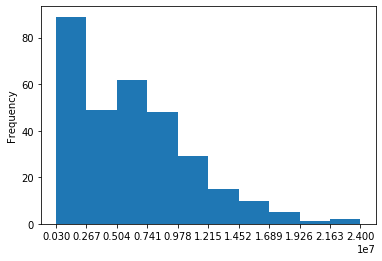

In [13]:
count, bin_edges = np.histogram(df3['AVERAGE SALE PRICE'])
df3['AVERAGE SALE PRICE'].plot(kind='hist', xticks = bin_edges)

In [14]:
df4 = df3[['NEIGHBORHOOD', 'NUMBER OF SALES']]

In [15]:
pivot = pd.pivot_table(df3,index=["NEIGHBORHOOD"], aggfunc = 'sum')

df5 = pivot.reset_index().rename_axis(None, axis=1)
df5.head()

,NEIGHBORHOOD,AVERAGE SALE PRICE,HIGHEST SALE PRICE,LOWEST SALE PRICE,MEDIAN SALE PRICE,NUMBER OF SALES,Type of Home for Alg
0,ALPHABET CITY,35448605,36513700,34383509,35448605,9,15
1,CHELSEA,101401186,131163815,78070744,97425250,31,27
2,CLINTON,18767392,18767392,18767392,18767392,4,10
3,EAST VILLAGE,47918900,56126400,42551400,44538900,14,13
4,GRAMERCY,65243125,76697500,49450000,68962500,18,19


### Creating a Bar Chart in order to understand what is the highest Neighborhood on sales matter

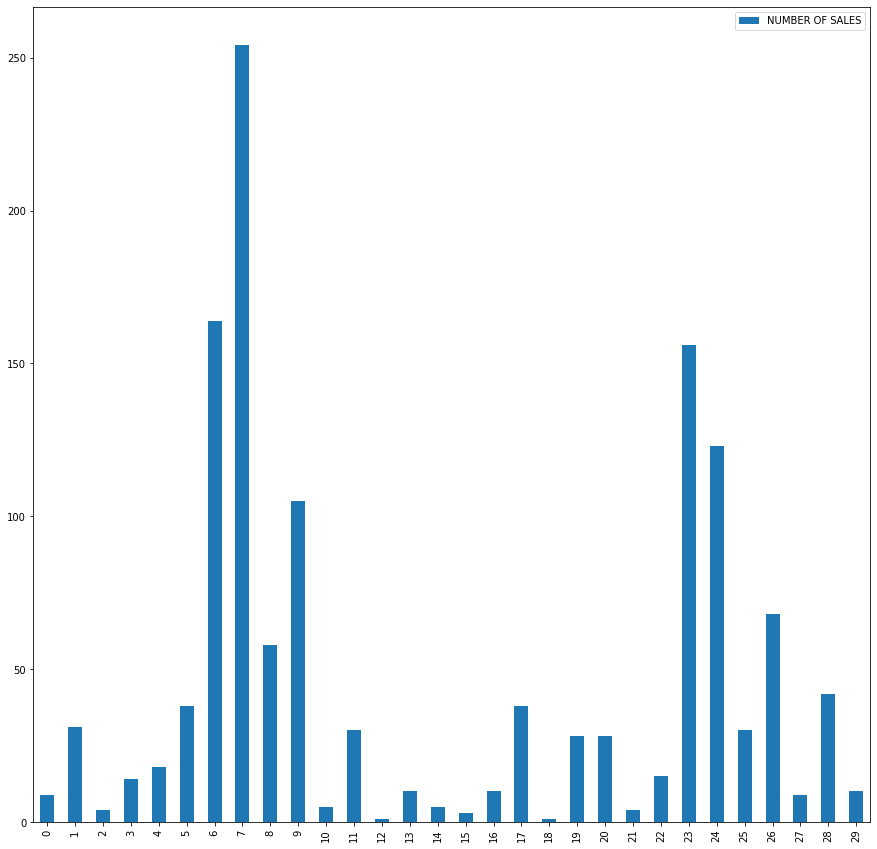

In [16]:
df6 = df5[['NUMBER OF SALES', 'NEIGHBORHOOD']]
df6.plot.bar(figsize = (15,15))

In [17]:
df6.sort_values(by=['NUMBER OF SALES'], inplace=True, ascending=False)

C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Select the 5 neighborhood with more sale, and with less sales.

In [18]:
Highest_n_sales = df6.head(5)
lowest_n_sales = df6.tail(5)

In [19]:
Highest_n_sales

,NUMBER OF SALES,NEIGHBORHOOD
7,254,HARLEM-CENTRAL
6,164,GREENWICH VILLAGE-WEST
23,156,UPPER EAST SIDE (59-79)
24,123,UPPER EAST SIDE (79-96)
9,105,HARLEM-UPPER


In [20]:
lowest_n_sales

,NUMBER OF SALES,NEIGHBORHOOD
21,4,SOUTHBRIDGE
2,4,CLINTON
15,3,LOWER EAST SIDE
18,1,MIDTOWN WEST
12,1,JAVITS CENTER


### Creating boxplot Graphic in order to analyse the price per dwelling of the neighborhoods

#### Creting an "price_per_dwelling" column.

In [21]:
pivot2 = pd.pivot_table(df3,index=["NEIGHBORHOOD"], aggfunc = 'mean')

create_p_home = pivot2.reset_index().rename_axis(None, axis=1)

merged_sum_avg = df5.merge(create_p_home, on = 'NEIGHBORHOOD')

In [22]:
merged_sum_avg['Price_per_dwelling'] = merged_sum_avg['AVERAGE SALE PRICE_y'] / merged_sum_avg['Type of Home for Alg_x']

In [23]:
merged_sum_avg.head()

,NEIGHBORHOOD,AVERAGE SALE PRICE_x,HIGHEST SALE PRICE_x,LOWEST SALE PRICE_x,MEDIAN SALE PRICE_x,NUMBER OF SALES_x,Type of Home for Alg_x,AVERAGE SALE PRICE_y,HIGHEST SALE PRICE_y,LOWEST SALE PRICE_y,MEDIAN SALE PRICE_y,NUMBER OF SALES_y,Type of Home for Alg_y,Price_per_dwelling
0,ALPHABET CITY,35448605,36513700,34383509,35448605,9,15,5.064086e+06,5.216243e+06,4.911930e+06,5.064086e+06,1.285714,2.142857,337605.761905
1,CHELSEA,101401186,131163815,78070744,97425250,31,27,7.242942e+06,9.368844e+06,5.576482e+06,6.958946e+06,2.214286,1.928571,268257.105820
2,CLINTON,18767392,18767392,18767392,18767392,4,10,4.691848e+06,4.691848e+06,4.691848e+06,4.691848e+06,1.000000,2.500000,469184.800000
3,EAST VILLAGE,47918900,56126400,42551400,44538900,14,13,6.845557e+06,8.018057e+06,6.078771e+06,6.362700e+06,2.000000,1.857143,526581.318681
4,GRAMERCY,65243125,76697500,49450000,68962500,18,19,7.249236e+06,8.521944e+06,5.494444e+06,7.662500e+06,2.000000,2.111111,381538.742690


In [24]:
df3['Price_per_dwelling'] = df3['AVERAGE SALE PRICE'] / df3['Type of Home for Alg']

C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Plotting BoxPlot

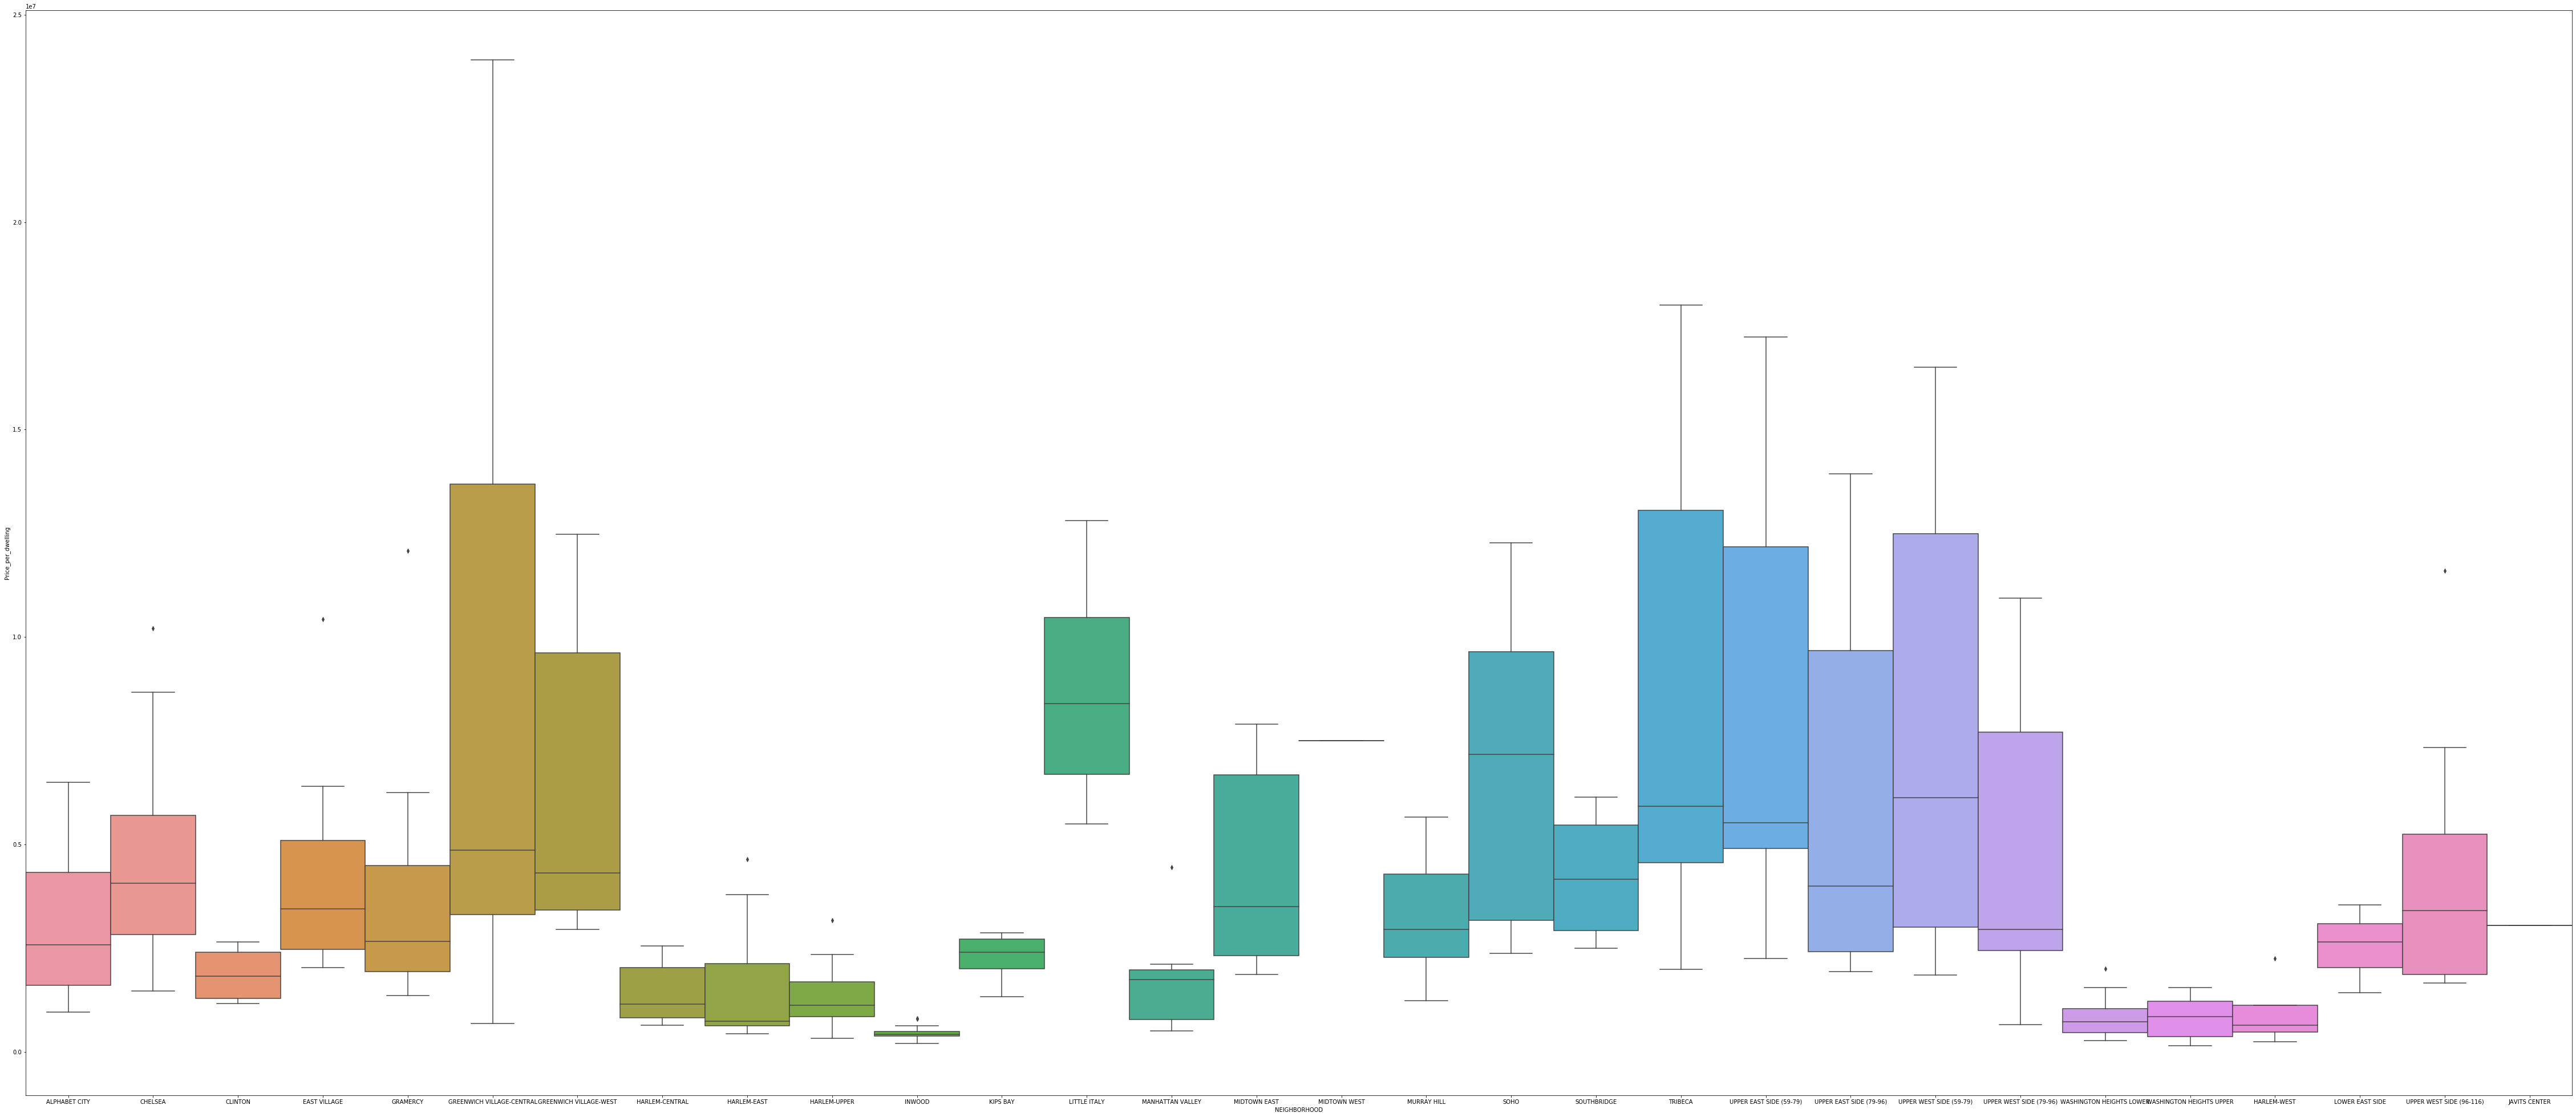

In [25]:
plt.figure(figsize=(80,35))
ax = sns.boxplot(x="NEIGHBORHOOD", y="Price_per_dwelling", data=df3,  width=1)

In [26]:
merged_sum_avg.sort_values(by=['Price_per_dwelling'], inplace=True, ascending=False)

### The five Neighborhood with the highest and lowest dwelling price

In [27]:
expensive_Dw_price = merged_sum_avg[['NEIGHBORHOOD', 'Price_per_dwelling', 'NUMBER OF SALES_x']].head(5)

In [28]:
expensive_Dw_price

,NEIGHBORHOOD,Price_per_dwelling,NUMBER OF SALES_x
18,MIDTOWN WEST,7.500000e+06,1
12,JAVITS CENTER,3.050000e+06,1
14,LITTLE ITALY,2.193344e+06,5
21,SOUTHBRIDGE,1.067708e+06,4
15,LOWER EAST SIDE,7.800000e+05,3


In [29]:
cheapest_Dw_price = merged_sum_avg[['NEIGHBORHOOD', 'Price_per_dwelling', 'NUMBER OF SALES_x']].tail(5)

In [30]:
cheapest_Dw_price

,NEIGHBORHOOD,Price_per_dwelling,NUMBER OF SALES_x
7,HARLEM-CENTRAL,63351.797840,254
8,HARLEM-EAST,62416.915225,58
9,HARLEM-UPPER,58452.888889,105
28,WASHINGTON HEIGHTS LOWER,50394.216837,42
11,INWOOD,32763.963211,30


# Clustering and Machine Learning Process

### Clustering the information from Price_per_dwelling

In [31]:
merged = merged_sum_avg[['NEIGHBORHOOD','Price_per_dwelling' ]]

In [32]:
from sklearn.cluster import KMeans
kclusters = 4

manhattan_grouped_clustering1 = merged.drop('NEIGHBORHOOD', 1)


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering1)

kmeans.labels_[0:10]

array([2, 0, 0, 3, 3, 3, 3, 3, 3, 3])

### Seeing the Cluster and rename the cluster numbers to represent the data better

In [33]:
merged.insert(0, 'Cluster Labels', kmeans.labels_)

#### Seeing the cluster to understand better the classification

In [34]:
c1 = merged[merged['Cluster Labels'] == 1]

In [35]:
c2= merged[merged['Cluster Labels'] == 2]

In [36]:
c3 = merged[merged['Cluster Labels'] == 3]

In [37]:
c4 = merged[merged['Cluster Labels'] == 0]

####  Renaming the columns for better data visualization further

In [38]:
merged['Cluster Labels'] = merged['Cluster Labels'].astype(str)
merged['Cluster Labels'] = merged['Cluster Labels'].str.replace("1","Lower Prices Per Dwelling")
merged['Cluster Labels'] = merged['Cluster Labels'].str.replace("2","Highest Prices Per Dwelling")
merged['Cluster Labels'] = merged['Cluster Labels'].str.replace("3","Regular Prices Per Dwelling")
merged['Cluster Labels'] = merged['Cluster Labels'].str.replace("0","Highest Prices Per Dwelling")

C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

### Clustering information by Number of sales of property

In [39]:
merged1 = merged_sum_avg[['NEIGHBORHOOD','NUMBER OF SALES_x' ]]

In [41]:
from sklearn.cluster import KMeans
kclusters = 3

manhattan_grouped_clustering = merged1.drop('NEIGHBORHOOD', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2])

#### Seeing the clustering and renaming information for better final understanding

In [42]:
merged1.insert(0, 'Cluster Labels', kmeans.labels_)

In [43]:
c1c = merged1[merged1['Cluster Labels'] == 1]
c2c = merged1[merged1['Cluster Labels'] == 2]
c0c = merged1[merged1['Cluster Labels'] == 0]

In [44]:
merged1['Cluster Labels'] = merged1['Cluster Labels'].astype(str)
merged1['Cluster Labels'] = merged1['Cluster Labels'].str.replace("1","Worse Selling Regions")
merged1['Cluster Labels'] = merged1['Cluster Labels'].str.replace("2","Worse Selling Regions")
merged1['Cluster Labels'] = merged1['Cluster Labels'].str.replace("0","Best Selling Regions")

C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

## Extracting information from Foursquare in order to enrich our final base

In [45]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate  is {}, {}.'.format(latitude, longitude))

manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

The geograpical coordinate  is 40.7127281, -74.0060152.


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


#### Importing and formatting Ny Data

In [46]:
import urllib.request, json 
with urllib.request.urlopen("https://cocl.us/new_york_dataset") as url:
    newyork_data = json.loads(url.read().decode())

In [47]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_latitude = neighborhood_latlon[1]
    neighborhood_longitude = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_latitude,
                                          'Longitude': neighborhood_longitude}, ignore_index=True)

In [48]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [49]:
VERSION = '20181020'


CLIENT_ID = 'TMDI5OONSYJOPAULYX5M54FUCIKZNMDDUTFZQGKUXEZ5O2RI' # your Foursquare ID
CLIENT_SECRET = 'FEZI003TTQV2TG0MKJ5D1YSR2UDSEK4II2XUT4MHXJU1UQEH' # your Foursquare Secret


print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TMDI5OONSYJOPAULYX5M54FUCIKZNMDDUTFZQGKUXEZ5O2RI
CLIENT_SECRET:FEZI003TTQV2TG0MKJ5D1YSR2UDSEK4II2XUT4MHXJU1UQEH


### Selecting Manhattan Data

In [50]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [51]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

In [52]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] 
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] 

neighborhood_name = manhattan_data.loc[0, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


### Extracting Manhatham Information from FourSquare

In [53]:
LIMIT = 100 

radius = 500 

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)




In [54]:
results = requests.get(url).json()

In [55]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [56]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Starbucks,Coffee Shop,40.877531,-73.905582
4,Dunkin',Donut Shop,40.877136,-73.906666


In [57]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [58]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Preparing information for clustering (get dummies)

In [59]:
# Encoding for clustering
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group the data and see the means to cluster

In [60]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.015152,0.045455,0.000000,0.015152,0.000000
1,Carnegie Hill,0.000000,0.000000,0.00,0.000000,0.012195,0.000000,0.000000,0.000000,0.012195,...,0.00,0.024390,0.000000,0.000000,0.000000,0.012195,0.036585,0.000000,0.000000,0.036585
2,Central Harlem,0.000000,0.000000,0.00,0.068182,0.045455,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Chelsea,0.000000,0.000000,0.00,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000
4,Chinatown,0.000000,0.000000,0.00,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Civic Center,0.000000,0.000000,0.00,0.000000,0.051546,0.010309,0.000000,0.000000,0.000000,...,0.00,0.010309,0.000000,0.000000,0.010309,0.020619,0.020619,0.000000,0.000000,0.030928
6,Clinton,0.000000,0.000000,0.00,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.020000,0.030000,0.000000,0.000000,0.000000
7,East Harlem,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,East Village,0.000000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,0.010000,0.010000,...,0.00,0.020000,0.000000,0.000000,0.000000,0.030000,0.010000,0.000000,0.000000,0.000000
9,Financial District,0.000000,0.000000,0.00,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.010000,0.010000


### Getting info from neighborhood to see the caracteristics of that region

In [61]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.11
1    Coffee Shop  0.08
2          Hotel  0.06
3  Memorial Site  0.05
4      Wine Shop  0.05


----Carnegie Hill----
                 venue  freq
0          Coffee Shop  0.10
1          Pizza Place  0.05
2          Yoga Studio  0.04
3  Japanese Restaurant  0.04
4            Bookstore  0.04


----Central Harlem----
                venue  freq
0  Chinese Restaurant  0.07
1  African Restaurant  0.07
2   French Restaurant  0.05
3  Seafood Restaurant  0.05
4      Cosmetics Shop  0.05


----Chelsea----
                 venue  freq
0          Art Gallery  0.13
1          Coffee Shop  0.07
2                 Café  0.04
3       Ice Cream Shop  0.04
4  American Restaurant  0.03


----Chinatown----
                 venue  freq
0   Chinese Restaurant  0.07
1               Bakery  0.04
2         Cocktail Bar  0.04
3      Bubble Tea Shop  0.04
4  American Restaurant  0.03


----Civic Center----
                 venue  freq
0      

In [62]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Getting top Venues for each Neighborhood

In [63]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Wine Shop,Memorial Site,Gym,Shopping Mall,Plaza,Playground,Food Court
1,Carnegie Hill,Coffee Shop,Pizza Place,Café,Japanese Restaurant,Gym,Grocery Store,Yoga Studio,Bookstore,Bar,Wine Shop
2,Central Harlem,Chinese Restaurant,African Restaurant,Bar,American Restaurant,Cosmetics Shop,French Restaurant,Seafood Restaurant,Dessert Shop,Boutique,Gym / Fitness Center
3,Chelsea,Art Gallery,Coffee Shop,Café,Ice Cream Shop,American Restaurant,Market,Seafood Restaurant,Boutique,Cupcake Shop,Cycle Studio
4,Chinatown,Chinese Restaurant,Bakery,Bubble Tea Shop,Cocktail Bar,Spa,Coffee Shop,American Restaurant,Optical Shop,Salon / Barbershop,Mexican Restaurant


# Starting Final Phase: Merging Data Sets

## Sales Clustering + Price_per_Dwelling + Neighborhood Caracteristics

### Preparing Data to merge

In [64]:
neighborhoods_venues_sorted['Neighborhood'] = neighborhoods_venues_sorted['Neighborhood'].str.upper() 
neighborhoods_venues_sorted.rename(columns={'Neighborhood': 'NEIGHBORHOOD'}, inplace=True)

In [65]:
merged['NEIGHBORHOOD'] = merged['NEIGHBORHOOD'].str.upper()
merged['NEIGHBORHOOD'] = merged['NEIGHBORHOOD'].str.strip()
merged['NEIGHBORHOOD'] = merged['NEIGHBORHOOD'].str.replace("-"," ")

C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pintof\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [66]:
neighborhoods_venues_sorted['NEIGHBORHOOD'] = neighborhoods_venues_sorted['NEIGHBORHOOD'].str.upper()
neighborhoods_venues_sorted['NEIGHBORHOOD'] = neighborhoods_venues_sorted['NEIGHBORHOOD'].str.strip()
neighborhoods_venues_sorted['NEIGHBORHOOD'] = neighborhoods_venues_sorted['NEIGHBORHOOD'].str.replace("-"," ")


#### Merging Neighborhood Venues clustering database with the Price Dwelling clustering database

In [67]:
almerge = merged.merge(neighborhoods_venues_sorted, on= 'NEIGHBORHOOD')

#### Merging the below database with Sales Number Clustering info

In [77]:
lastmerge = almerge.merge(merged1, on= 'NEIGHBORHOOD')
lastmerge = lastmerge.drop('NUMBER OF SALES_x',1)

#### Renaming columns for better Visualization

In [79]:
final_sheet = lastmerge.rename(columns={'Cluster Labels_x': 'Price per Dwelling segmentation', 'Cluster Labels_y': 'Selling per Region segmentation',  'NUMBER OF SALES_x': 'Number of Sales'})

# Final output

In [80]:
final_sheet

,Price per Dwelling segmentation,NEIGHBORHOOD,Price_per_dwelling,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Selling per Region segmentation
0,Highest Prices Per Dwelling,LITTLE ITALY,2.193344e+06,Chinese Restaurant,Bubble Tea Shop,Café,Spa,Bakery,Mediterranean Restaurant,Hotel,Thai Restaurant,Pizza Place,Ice Cream Shop,Best Selling Regions
1,Regular Prices Per Dwelling,LOWER EAST SIDE,7.800000e+05,Chinese Restaurant,Café,Pharmacy,Art Gallery,Bakery,Park,Cocktail Bar,Mediterranean Restaurant,Women's Store,Japanese Restaurant,Best Selling Regions
2,Regular Prices Per Dwelling,TRIBECA,6.543844e+05,Italian Restaurant,Park,American Restaurant,Bakery,Café,Spa,Wine Bar,Skate Park,Scenic Lookout,Hotel,Best Selling Regions
3,Regular Prices Per Dwelling,EAST VILLAGE,5.265813e+05,Cocktail Bar,Pizza Place,Mexican Restaurant,Bar,Coffee Shop,Wine Bar,Juice Bar,Ice Cream Shop,Japanese Restaurant,Ramen Restaurant,Best Selling Regions
4,Regular Prices Per Dwelling,SOHO,4.733399e+05,Italian Restaurant,Mediterranean Restaurant,Café,Sandwich Place,Gym,Coffee Shop,Sushi Restaurant,Ice Cream Shop,French Restaurant,Clothing Store,Best Selling Regions
5,Regular Prices Per Dwelling,CLINTON,4.691848e+05,Theater,Gym / Fitness Center,Coffee Shop,Hotel,Gym,Italian Restaurant,Sandwich Place,Pizza Place,Spa,American Restaurant,Best Selling Regions
6,Regular Prices Per Dwelling,GRAMERCY,3.815387e+05,Bagel Shop,Italian Restaurant,Bar,Pizza Place,Coffee Shop,Playground,Mexican Restaurant,Thai Restaurant,Grocery Store,American Restaurant,Best Selling Regions
7,Lower Prices Per Dwelling,CHELSEA,2.682571e+05,Art Gallery,Coffee Shop,Café,Ice Cream Shop,American Restaurant,Market,Seafood Restaurant,Boutique,Cupcake Shop,Cycle Studio,Best Selling Regions
8,Lower Prices Per Dwelling,MURRAY HILL,2.332665e+05,Coffee Shop,Sandwich Place,Japanese Restaurant,Hotel,Pizza Place,Gym / Fitness Center,Grocery Store,Mediterranean Restaurant,Juice Bar,Indian Restaurant,Best Selling Regions
9,Lower Prices Per Dwelling,MANHATTAN VALLEY,1.976954e+05,Coffee Shop,Pizza Place,Bar,Mexican Restaurant,Yoga Studio,Grocery Store,Playground,Park,Latin American Restaurant,Korean Restaurant,Best Selling Regions
